# Explore S2S Metadata and API

This notebook walks through an example of exploring the Space2Stats Metadata, and then using the API to fetch flood data for various provinces within a country.

In [4]:
from typing import Dict

import folium as flm  # Comment out if you have not installed, or run pip install folium matplotlib mapclassify
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
from geojson_pydantic import Feature, Polygon
from lonboard import Map, ScatterplotLayer
from shapely import from_geojson
from pystac import Asset, CatalogType, Collection, Item, Catalog

In [6]:
BASE_URL = "https://space2stats.ds.io"
FIELDS_ENDPOINT = f"{BASE_URL}/fields"
SUMMARY_ENDPOINT = f"{BASE_URL}/summary"
catalog = Catalog.from_file("https://raw.githubusercontent.com/worldbank/DECAT_Space2Stats/refs/heads/main/space2stats_api/src/space2stats_ingest/METADATA/stac/catalog.json")

## Helper Functions

The following python functions are being developed to help interact with the API.

In [26]:
def get_topics(catalog: Catalog) -> Dict:
    """Get list of dataset themes (topics) from the catalog."""
    items = catalog.get_all_items()
    items = list(items)
    topics = [{i.id: {k: v for k, v in i.properties.items() if k in ["name", "description", "source_data"]}} for i in items]
    return topics

def get_fields(item_id: str, catalog: Catalog) -> Dict:
    """Get description of variables for a given dataset (item)."""
    collection = next(catalog.get_collections())
    item = collection.get_item(item_id)
    fields = item.properties["table:columns"]
    return pd.DataFrame(fields)

def fetch_admin_boundaries(iso3: str, adm: str) -> gpd.GeoDataFrame:
    """Fetch administrative boundaries from GeoBoundaries API."""
    url = f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/"
    res = requests.get(url).json()
    return gpd.read_file(res["gjDownloadURL"])

def get_summary(gdf: gpd.GeoDataFrame, spatial_join_method: str, fields: list, geometry: str):
    """Fetch summary data for a geodataframe."""
    
    res_all = {}
    for idx, row in gdf.iterrows():
        request_payload = {
            "aoi": {
                "type": "Feature",
                "geometry": row.geometry.__geo_interface__,
                "properties": {},
            },
            "spatial_join_method": spatial_join_method,
            "fields": fields,
            "geometry": geometry,
        }
        response = requests.post(SUMMARY_ENDPOINT, json=request_payload)

        if response.status_code != 200:
            raise Exception(f"Failed to get summary: {response.text}")
        
        summary_data = response.json()
        if not summary_data:
            print(f"Failed to get summary for {idx}")
            summary_data = pd.DataFrame()  # Return an empty DataFrame if no data

        df = pd.DataFrame(summary_data)
        res_all[idx] = df
    
    res_all = pd.concat(res_all, names=["index_gdf", "index_h3"])
    res_all = res_all.reset_index()
    gdf.drop(columns=["geometry"], inplace=True)
    res_all = gdf.merge(res_all, left_index=True, right_on="index_gdf")
    return res_all

## Query Metadata

Each dataset in Space2Stats is stored as a STAC item. The following function provides key details regarding each dataset.

In [9]:
topics = get_topics(catalog)
topics

[{'space2stats_population_2020': {'name': 'Population',
   'description': 'Gridded population disaggregated by gender.',
   'source_data': 'WorldPop gridded population, 2020, Unconstrained, UN-Adjusted, https://www.worldpop.org/methods/top_down_constrained_vs_unconstrained/'}},
 {'flood_exposure_15cm_1in100': {'name': 'Population Exposed to Floods',
   'description': 'Population where flood depth is greater than 15 cm, 1-in-100 return period.',
   'source_data': 'Fathom 3.0 High Resolution Global Flood Maps Including Climate Scenarios, https://datacatalog.worldbank.org/search/dataset/0065653/Fathom-3-0---High-Resolution-Global-Flood-Maps-Including-Climate-Scenarios'}},
 {'nighttime_lights_2013': {'name': 'Nighttime Lights',
   'description': 'Sum of luminosity values measured by monthly composites from VIIRS satellite.',
   'source_data': 'World Bank - Light Every Night, https://registry.opendata.aws/wb-light-every-night/'}},
 {'urbanization_ghssmod': {'name': 'Urbanization by populati

We can extract additional metadata like fields and descriptions using the item id.

In [11]:
fields = get_fields("flood_exposure_15cm_1in100", catalog)
fields

,name,description,type
0,hex_id,H3 unique identifier,object
1,pop,"Sum of Gridded Population, 2020",float32
2,pop_flood,Sum of population exposed to floods greater th...,float64
3,pop_flood_pct,Percent of population exposed to floods greate...,float64


Alternatively, we can also explore the fields avaialble via the API fields endpoint:

In [3]:
response = requests.get(FIELDS_ENDPOINT)
if response.status_code != 200:
    raise Exception(f"Failed to get fields: {response.text}")

available_fields = response.json()
print("Available Fields:", available_fields)

Available Fields: ['pop_flood_pct', 'ogc_fid', 'sum_pop_f_0_2020', 'sum_pop_f_10_2020', 'sum_pop_f_15_2020', 'sum_pop_f_1_2020', 'sum_pop_f_20_2020', 'sum_pop_f_25_2020', 'sum_pop_f_30_2020', 'sum_pop_f_35_2020', 'sum_pop_f_40_2020', 'sum_pop_f_45_2020', 'sum_pop_f_50_2020', 'sum_pop_f_55_2020', 'sum_pop_f_5_2020', 'sum_pop_f_60_2020', 'sum_pop_f_65_2020', 'sum_pop_f_70_2020', 'sum_pop_f_75_2020', 'sum_pop_f_80_2020', 'sum_pop_m_0_2020', 'sum_pop_m_10_2020', 'sum_pop_m_15_2020', 'sum_pop_m_1_2020', 'sum_pop_m_20_2020', 'sum_pop_m_25_2020', 'sum_pop_m_30_2020', 'sum_pop_m_35_2020', 'sum_pop_m_40_2020', 'sum_pop_m_45_2020', 'sum_pop_m_50_2020', 'sum_pop_m_55_2020', 'sum_pop_m_5_2020', 'sum_pop_m_60_2020', 'sum_pop_m_65_2020', 'sum_pop_m_70_2020', 'sum_pop_m_75_2020', 'sum_pop_m_80_2020', 'sum_pop_m_2020', 'sum_pop_f_2020', 'sum_pop_2020', 'pop', 'pop_flood']


## Extract Data

Let's work with the subset of fields from the flood exposure item: `['pop', 'pop_flood', 'pop_flood_pct']`

In [14]:
flood_vars = ['pop', 'pop_flood', 'pop_flood_pct']

We will define our AOIs by fetching admin boundaries from the GeoBoundaries project.

In [44]:
ISO3 = "BDI" # South Sudan
ADM = "ADM0" # Level 2 administrative boundaries
adm_boundaries = fetch_admin_boundaries(ISO3, ADM)

In [46]:
adm_boundaries.bounds

,minx,miny,maxx,maxy
0,29.038924,-4.468958,30.850461,-2.310523


In [42]:
adm_boundaries.bounds

,minx,miny,maxx,maxy
0,33.911819,-4.702271,41.906258,5.430648


In [39]:
# adm_boundaries.__geo_interface__

In [15]:
ISO3 = "SSD" # South Sudan
ADM = "ADM2" # Level 2 administrative boundaries
adm_boundaries = fetch_admin_boundaries(ISO3, ADM)

In [16]:
len(adm_boundaries)

78

In [18]:
rows = adm_boundaries.iloc[0:5]
rows

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Morobo,,79223893B16328156709571,SSD,ADM2,"POLYGON ((30.56014 3.80448, 30.56025 3.80123, ..."
1,Kajo-keji,,79223893B65724383376583,SSD,ADM2,"POLYGON ((31.21043 4.02022, 31.09764 3.97353, ..."
2,Lainya,,79223893B40788586970477,SSD,ADM2,"POLYGON ((31.09684 3.73816, 31.097 3.738, 31.0..."
3,Yei,,79223893B15931514297219,SSD,ADM2,"POLYGON ((30.92897 3.92614, 30.92401 3.95754, ..."
4,Juba,,79223893B61077901252755,SSD,ADM2,"POLYGON ((31.72803 3.99162, 31.72429 4.00022, ..."


In [27]:
df = get_summary(adm_boundaries, "centroid", flood_vars, "polygon")

In [31]:
df

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,index_gdf,index_h3,hex_id,geometry,pop,pop_flood,pop_flood_pct
0,Morobo,,79223893B16328156709571,SSD,ADM2,0,0,866ae1067ffffff,"{""type"":""Polygon"",""coordinates"":[[[30.62327290...",4204.43850,609.631552,0.144997
1,Morobo,,79223893B16328156709571,SSD,ADM2,0,1,866ae106fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.68007919...",4776.96300,459.478346,0.096186
2,Morobo,,79223893B16328156709571,SSD,ADM2,0,2,866ae114fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.61445415...",3752.40040,341.734756,0.091071
3,Morobo,,79223893B16328156709571,SSD,ADM2,0,3,866ae116fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.60563958...",3304.66060,392.324178,0.118718
4,Morobo,,79223893B16328156709571,SSD,ADM2,0,4,866ae132fffffff,"{""type"":""Polygon"",""coordinates"":[[[30.84166572...",7512.33200,865.229318,0.115175
...,...,...,...,...,...,...,...,...,...,...,...,...
17479,Maban,,79223893B87220542132951,SSD,ADM2,77,326,866a66acfffffff,"{""type"":""Polygon"",""coordinates"":[[[32.98177964...",457.72247,121.194057,0.264776
17480,Maban,,79223893B87220542132951,SSD,ADM2,77,327,866a66aefffffff,"{""type"":""Polygon"",""coordinates"":[[[32.97756460...",473.77550,116.663865,0.246243
17481,Maban,,79223893B87220542132951,SSD,ADM2,77,328,866a66b4fffffff,"{""type"":""Polygon"",""coordinates"":[[[33.01472066...",179.20746,97.541596,0.544294
17482,Maban,,79223893B87220542132951,SSD,ADM2,77,329,866a66b67ffffff,"{""type"":""Polygon"",""coordinates"":[[[32.95642415...",212.50433,125.395232,0.590083


In [ ]:
def fetch_summary_data(feature: Dict) -> pd.DataFrame:
    """Fetch summary data for each administrative feature."""
    request_payload = {
        "aoi": feature,
        "spatial_join_method": "touches",
        "fields": ["sum_pop_2020"],
        "geometry": "point",
    }
    response = requests.post(SUMMARY_ENDPOINT, json=request_payload)
    if response.status_code != 200:
        raise Exception(f"Failed to get summary: {response.text}")

    summary_data = response.json()
    if not summary_data:
        print(f"Failed to get summary for {feature['id']}")
        return pd.DataFrame()  # Return an empty DataFrame if no data

    df = pd.DataFrame(summary_data)
    df["adm_id"] = int(feature["id"])
    df["adm_name"] = feature["properties"]["shapeName"]
    df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
    return df

In [ ]:
geojson_str = adm_boundaries.to_json()
adm_geojson = json.loads(geojson_str)
adm_features = adm_geojson["features"]

gdfs = []
for i, feature in enumerate(adm_features):
    df = fetch_summary_data(feature)
    if not df.empty:
        gdfs.append(gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326"))
        print(feature["properties"]["shapeName"], i)

# Concatenate all GeoDataFrames into a single GeoDataFrame
gdf = pd.concat(gdfs, ignore_index=True)

# Display the GeoDataFrame structure
gdf.head()

In [8]:
# Define the Request Payload
request_payload = {
    "aoi": aoi,
    "spatial_join_method": "touches",
    "fields": ["pop_flood", "sum_pop_2020"],
    "geometry": "polygon",
}

# Get Summary Data
response = requests.post(SUMMARY_ENDPOINT, json=request_payload)
if response.status_code != 200:
    raise Exception(f"Failed to get summary: {response.text}")

summary_data = response.json()
df = pd.DataFrame(summary_data)

In [9]:
df.head()

,hex_id,geometry,pop_flood,sum_pop_2020
0,866a4a00fffffff,"{""type"":""Polygon"",""coordinates"":[[[36.20299996...",226.062337,1.593942e+10
1,866a4a017ffffff,"{""type"":""Polygon"",""coordinates"":[[[36.10071731...",435.410477,1.593942e+10
2,866a4a01fffffff,"{""type"":""Polygon"",""coordinates"":[[[36.15684403...",242.842412,1.593942e+10
3,866a4a047ffffff,"{""type"":""Polygon"",""coordinates"":[[[36.30522474...",58.138220,1.593942e+10
4,866a4a04fffffff,"{""type"":""Polygon"",""coordinates"":[[[36.36131294...",28.331685,1.593942e+10


In [12]:
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf.head()

,hex_id,geometry,pop_flood,sum_pop_2020
0,866a4a00fffffff,"POLYGON ((36.20300 5.09880, 36.21506 5.12917, ...",226.062337,1.593942e+10
1,866a4a017ffffff,"POLYGON ((36.10072 5.08631, 36.11279 5.11669, ...",435.410477,1.593942e+10
2,866a4a01fffffff,"POLYGON ((36.15684 5.06425, 36.16891 5.09464, ...",242.842412,1.593942e+10
3,866a4a047ffffff,"POLYGON ((36.30522 5.11127, 36.31726 5.14163, ...",58.138220,1.593942e+10
4,866a4a04fffffff,"POLYGON ((36.36131 5.08921, 36.37334 5.11957, ...",28.331685,1.593942e+10


In [16]:
# m = gdf.explore(
#     column="pop_flood",
#     tooltip="pop_flood",
#     cmap="Blues",
#     legend=True,
#     scheme="naturalbreaks",
#     legend_kwds=dict(colorbar=True, caption="Population", interval=False),
#     style_kwds=dict(weight=0, fillOpacity=0.8),
#     name="Population by Hexagon",
# )
# flm.LayerControl("topright", collapsed=False).add_to(m)
# m

In [10]:
# hex_poly = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

In [11]:
from h3 import h3
from shapely.geometry import Polygon, mapping

In [12]:
df.head()

,hex_id,geometry,sum_pop_2020
0,866a4a00fffffff,"POLYGON ((36.20299996606005 5.098799628235741,...",476.538185
1,866a4a017ffffff,POLYGON ((36.100717319471535 5.086305068324564...,676.912804
2,866a4a01fffffff,"POLYGON ((36.15684403643006 5.064251853622329,...",347.182722
3,866a4a047ffffff,POLYGON ((36.305224747656666 5.111270484730321...,380.988678
4,866a4a04fffffff,"POLYGON ((36.36131294528294 5.089212997855731,...",285.943490


In [13]:
df.loc[:, "geometry2"] = df["hex_id"].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True)))

In [15]:
df.head()

,hex_id,geometry,sum_pop_2020,geometry2
0,866a4a00fffffff,"POLYGON ((36.20299996606005 5.098799628235741,...",476.538185,"POLYGON ((36.20299996606005 5.098799628235741,..."
1,866a4a017ffffff,POLYGON ((36.100717319471535 5.086305068324564...,676.912804,POLYGON ((36.100717319471535 5.086305068324565...
2,866a4a01fffffff,"POLYGON ((36.15684403643006 5.064251853622329,...",347.182722,"POLYGON ((36.15684403643006 5.064251853622326,..."
3,866a4a047ffffff,POLYGON ((36.305224747656666 5.111270484730321...,380.988678,POLYGON ((36.305224747656666 5.111270484730318...
4,866a4a04fffffff,"POLYGON ((36.36131294528294 5.089212997855731,...",285.943490,POLYGON ((36.36131294528294 5.0892129978557294...


In [18]:
gdf = gpd.GeoDataFrame(df, geometry="geometry2", crs="EPSG:4326")

<Axes: >

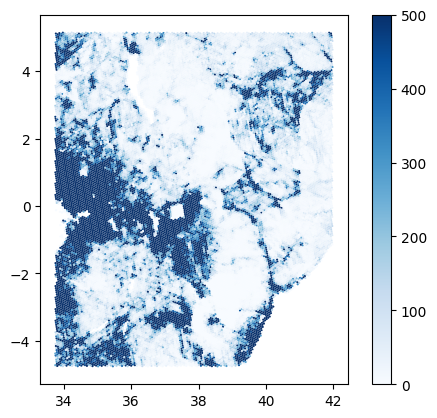

In [23]:
gdf.plot('pop_flood', legend=True, vmin=0, vmax=500, cmap='Blues')

In [9]:
gdf.loc[:, "geometry"] = gdf.geometry.representative_point()

In [10]:
# Define custom breaks and corresponding RGBA colors
breaks = [
    gdf["sum_pop_2020"].min(),
    1,
    1000,
    10000,
    50000,
    100000,
    200000,
    gdf["sum_pop_2020"].max(),
]
colors = np.array(
    [
        [211, 211, 211, 255],  # Light gray for 0
        [255, 255, 0, 255],  # Yellow for 1-1000
        [255, 165, 0, 255],  # Orange for 1000-10000
        [255, 0, 0, 255],  # Red for 10000-50000
        [128, 0, 128, 255],  # Purple for 50000-100000
        [0, 0, 255, 255],  # Blue for 100000-200000
        [0, 0, 139, 255],  # Dark blue for 200000+
    ]
)

# Function to assign colors based on custom bins


def assign_color(value, breaks, colors):
    for i in range(len(breaks) - 1):
        if breaks[i] <= value < breaks[i + 1]:
            return colors[i]
    return colors[-1]  # In case value exceeds all breaks


# Map sum_pop_2020 values to colors using the custom function
gdf["color"] = gdf["sum_pop_2020"].apply(lambda x: assign_color(x, breaks, colors))
colors = np.uint8(gdf["color"].tolist())

# Create the scatterplot layer with the assigned colors
layer = ScatterplotLayer.from_geopandas(gdf, get_radius=2000, get_fill_color=colors)

m = Map(layer)
m